<a href="https://colab.research.google.com/github/Broklink/Data-test/blob/main/Copy_of_Classification_NonLinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

## Data Gathering

In [ ]:
# Connect to GoogleDrive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read a file from GoogleDrive.
file_path = '/content/drive/MyDrive/Colab Notebooks/vgsales.csv'
df = pd.read_csv(file_path)

In [ ]:
# Display the first 5 rows to get a quick look at the data structure.
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [ ]:
# Check total length of dataset.
len(df)

16598

In [ ]:
# Check for data type in each column.
df.dtypes

,0
Rank,int64
Name,object
Platform,object
Year,float64
Genre,object
Publisher,object
NA_Sales,float64
EU_Sales,float64
JP_Sales,float64
Other_Sales,float64


In [ ]:
# แบ่งเป็น 3 class
bins = [0, 1, 5, df['Global_Sales'].max()]  # ขาย 0–1, 1–5, >5 ล้าน
labels = ['Low', 'Medium', 'High']

df['Global_Sales_class'] = pd.cut(df['Global_Sales'], bins=bins, labels=labels)

In [ ]:
# Define target and features.
label = 'Global_Sales_class'
exclude_columns = ['Rank']  # Rank ไม่ใช่ feature
features = [x for x in df.columns if x not in [label] + exclude_columns]

## Data Preprocessing

### Universal Data Cleaning

#### Duplicate Data

In [ ]:
# Check duplicate rows.
df[df.duplicated(keep=False)]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Global_Sales_class


#### Missing Data

In [ ]:
# Check for missing values in each column.
df.isnull().sum()

,0
Rank,0
Name,0
Platform,0
Year,271
Genre,0
Publisher,58
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


In [ ]:
# Remove missing target.
df = df.dropna(subset=['Year','Publisher'])
df = df.reset_index(drop=True)

#### Distribution

In [ ]:
# Check continuous features values.
df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000,16291.000000
mean,8290.190228,2006.405561,0.265647,0.147731,0.078833,0.048426,0.540910
std,4792.654450,5.832412,0.822432,0.509303,0.311879,0.190083,1.567345
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4132.500000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8292.000000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12439.500000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [ ]:
# Check categorical features values.
df['Platform'].value_counts()

,count
Platform,
DS,2131
PS2,2127
PS3,1304
Wii,1290
X360,1234
PSP,1197
PS,1189
PC,938
XB,803


In [ ]:
# Check another categorical features values.
df['Genre'].value_counts()

,count
Genre,
Action,3251
Sports,2304
Misc,1686
Role-Playing,1470
Shooter,1282
Adventure,1274
Racing,1225
Platform,875
Simulation,848


In [ ]:
# Check Total Charges those are not numberic.
df[df['Genre'].isna() | (df['Genre'].str.strip() == '')]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Global_Sales_class


In [ ]:
(df['Genre'].isna() | (df['Genre'].str.strip() == '')).sum()

np.int64(0)

In [ ]:
# Recheck data type.
df.dtypes

,0
Rank,int64
Name,object
Platform,object
Year,float64
Genre,object
Publisher,object
NA_Sales,float64
EU_Sales,float64
JP_Sales,float64
Other_Sales,float64


In [ ]:
# Recheck missing values.
df.isnull().sum()

,0
Rank,0
Name,0
Platform,0
Year,0
Genre,0
Publisher,0
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


#### Remove unused columns

In [ ]:
df = df.drop(columns=exclude_columns)

### Data Exploration

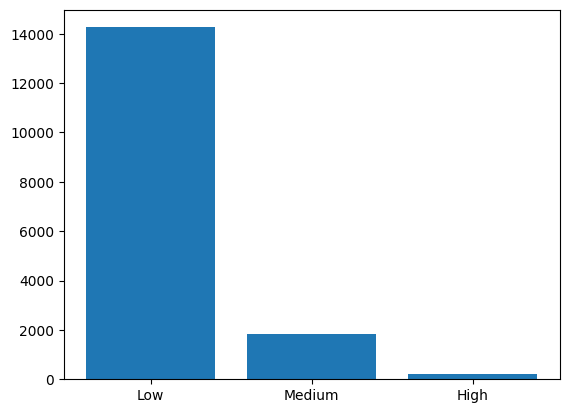

In [ ]:
# Check label distribution.
count_df = df[label].value_counts().reset_index()
count_df.columns = [label, 'count']
plt.bar(count_df[label], count_df['count'])
plt.show()

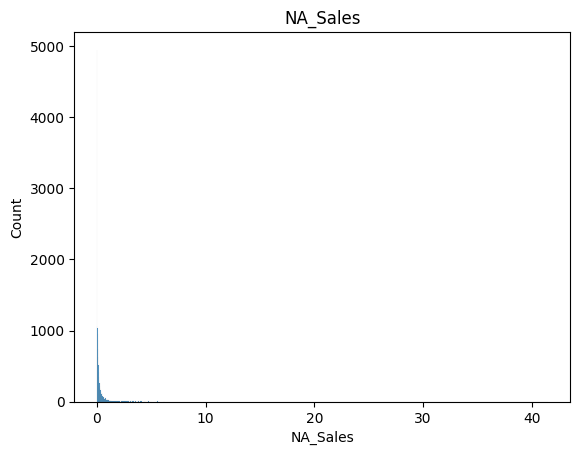

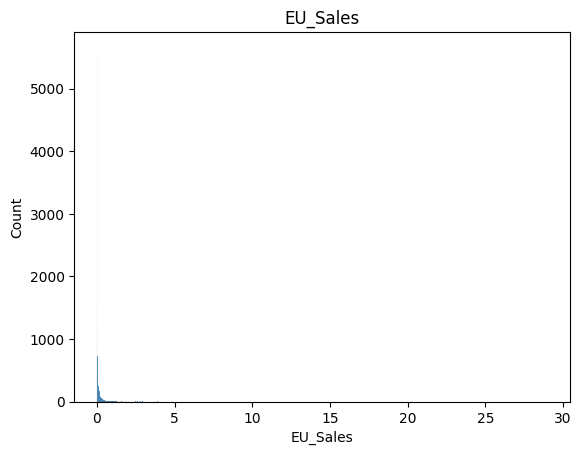

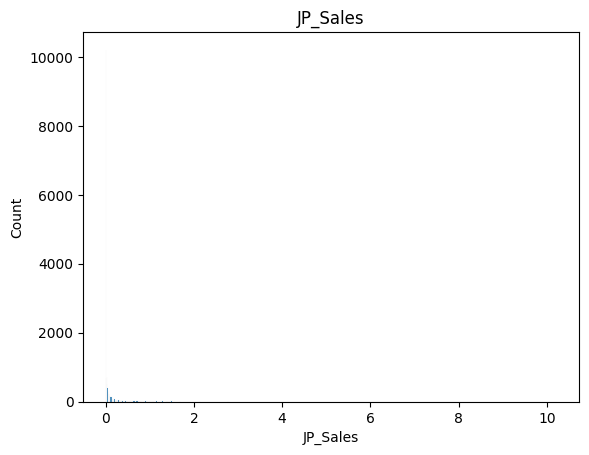

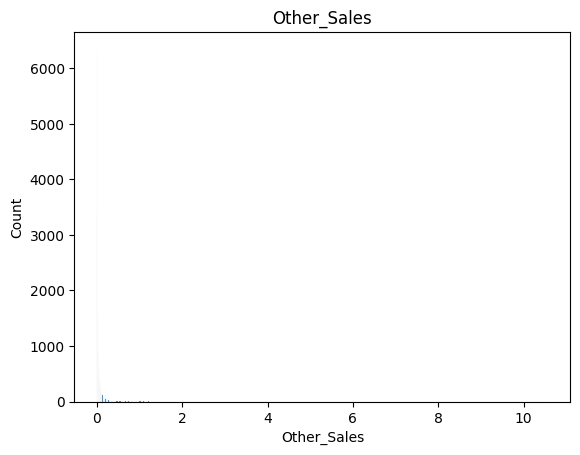

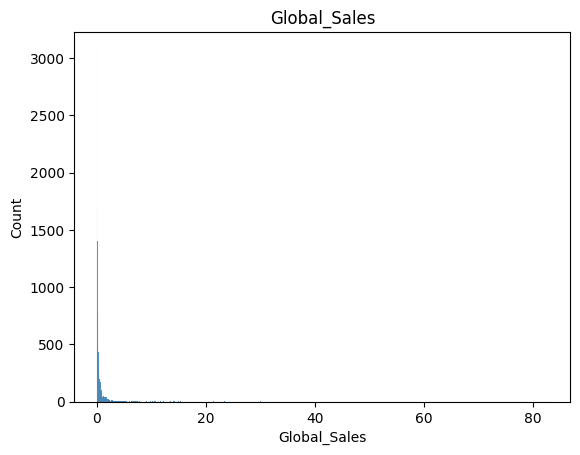

In [ ]:
# Check continuous features distribution.

num_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

for col in num_features:
    plt.figure()
    sns.histplot(df[col])
    plt.title(col)
    plt.show()

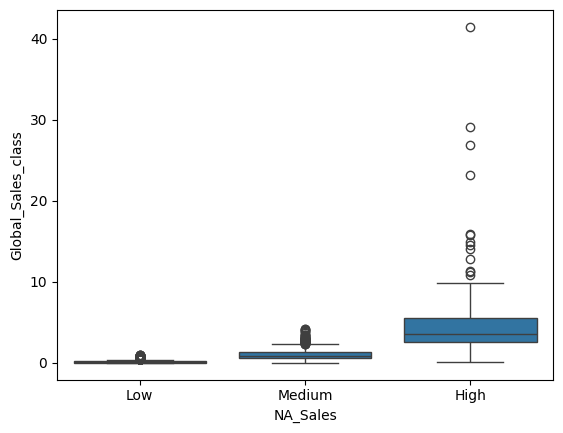

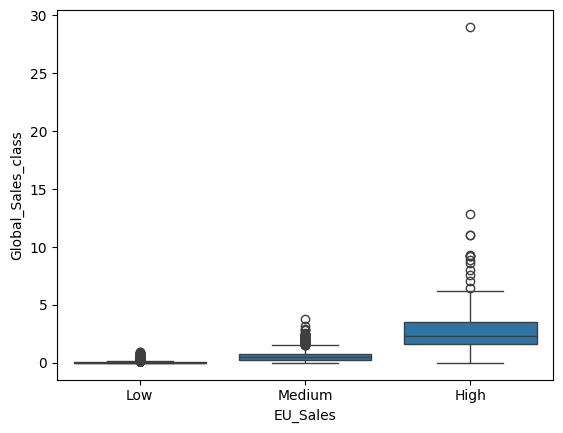

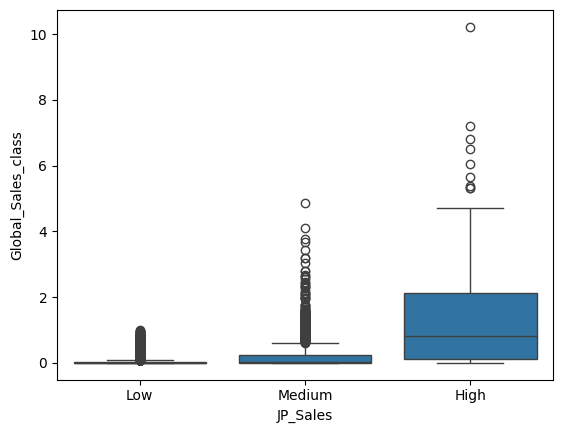

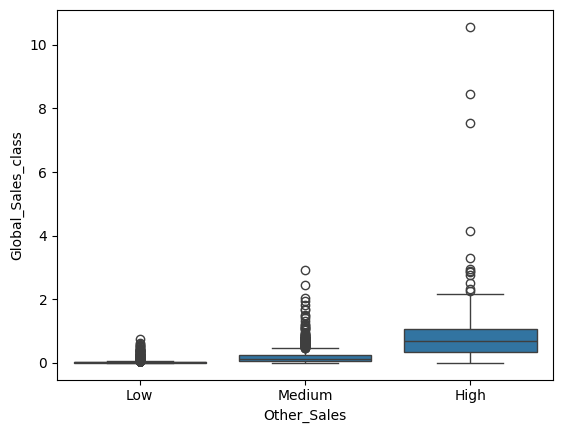

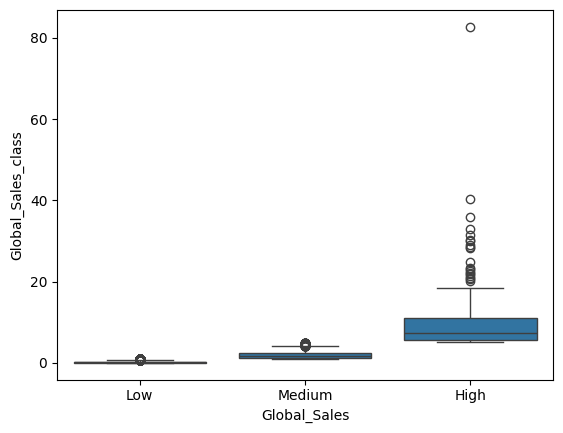

In [ ]:
# Check continuous features relationship.
for col in num_features:
  plt.figure()
  sns.boxplot(x=label, y=col, data=df)
  plt.xlabel(col)
  plt.ylabel(label)
  plt.show()

In [ ]:
# เลือก numerical features ที่จะ transform (ทุก market + global sales)
num_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# log-transform (เพิ่ม 1e-6 เพื่อหลีกเลี่ยง log(0))
for col in num_features:
    df[f'log_{col}'] = np.log(df[col] + 1e-6)

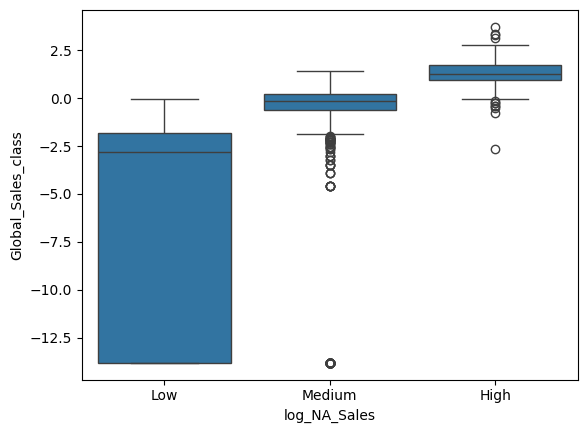

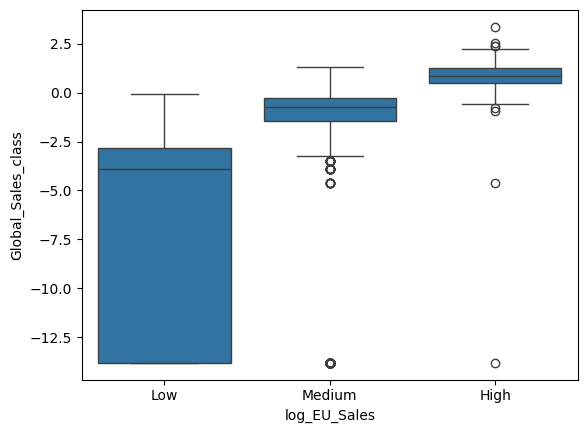

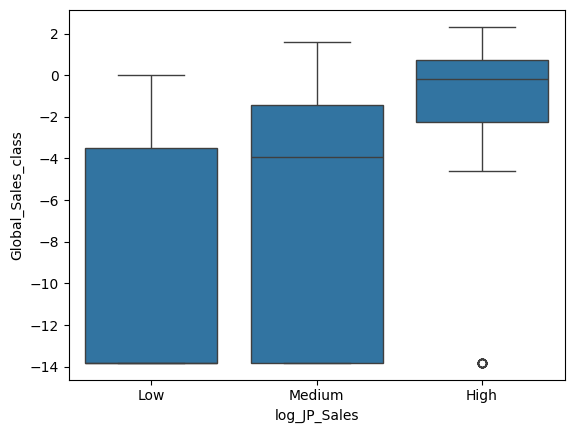

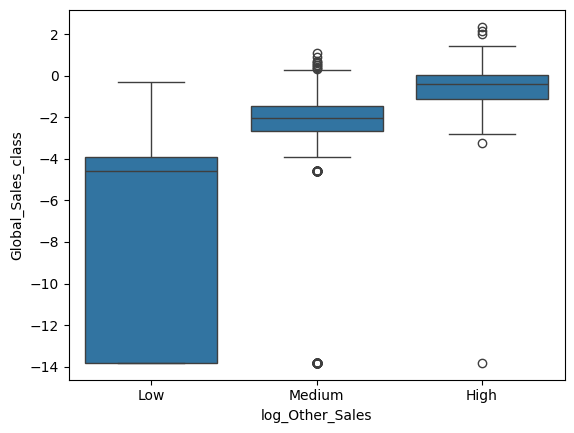

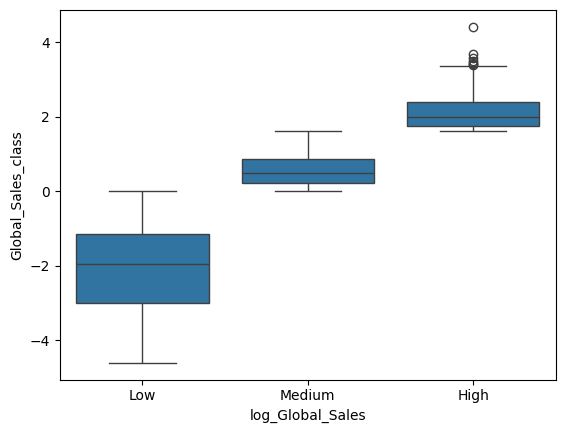

In [ ]:
# Re Check continuous features relationship.
for col in log_num_features:
  plt.figure()
  sns.boxplot(x=label, y=col, data=df)
  plt.xlabel(col)
  plt.ylabel(label)
  plt.show()

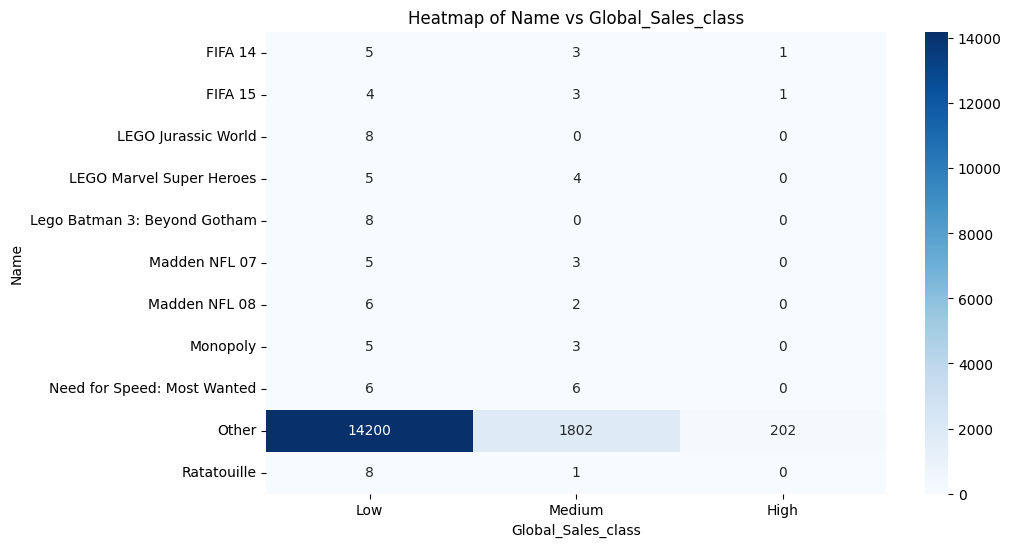

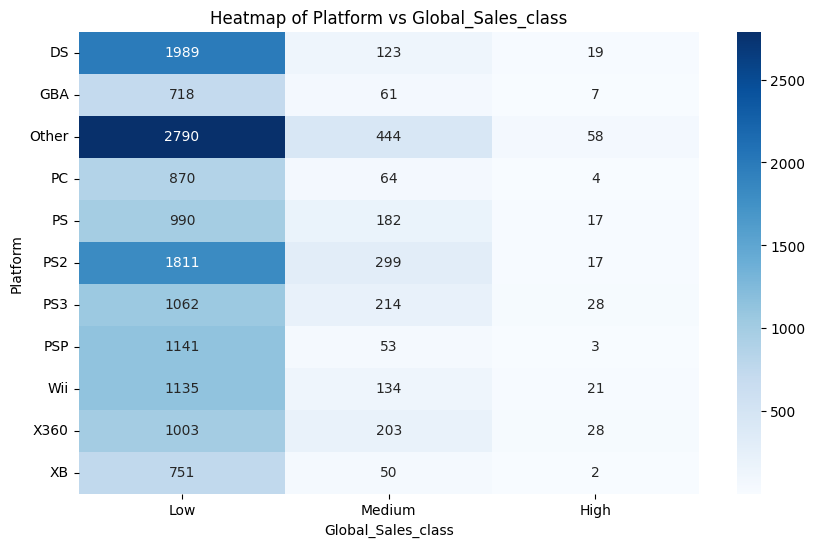

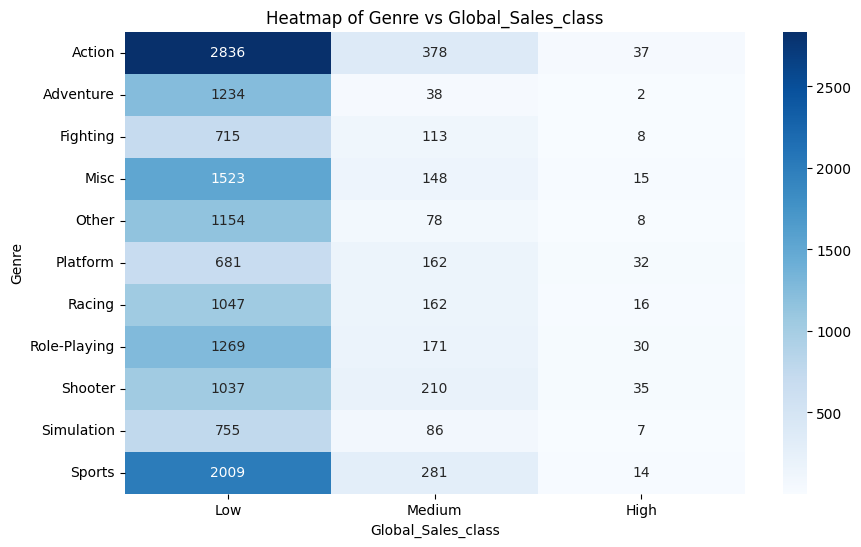

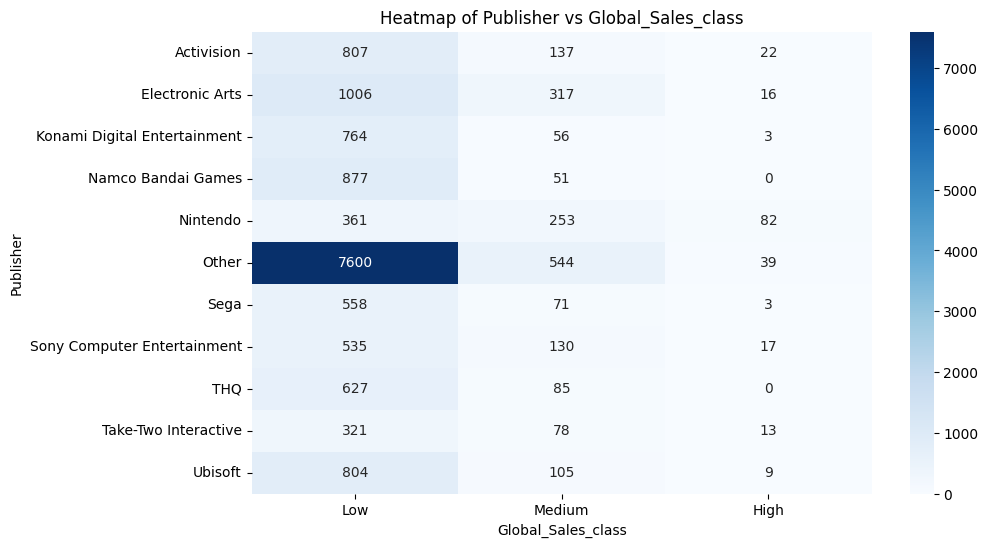

In [ ]:
# Check categorical features relationship.

categorical_features = ['Name', 'Platform', 'Genre', 'Publisher']
top_k = 10  # เลือก top 10

for col in categorical_features:
    top_categories = df[col].value_counts().nlargest(top_k).index
    df[f'{col}_top'] = df[col].where(df[col].isin(top_categories), 'Other')

    cross_tab = pd.crosstab(df[f'{col}_top'], df[label])

    plt.figure(figsize=(10,6))
    sns.heatmap(cross_tab, annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Heatmap of {col} vs {label}')
    plt.ylabel(col)
    plt.xlabel(label)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()

### Data Splitting

In [ ]:
# Defind X and y
X = df[features]
y = df[label]

In [ ]:
# Spit training set test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Spit validation set from training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
# Reset index
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Data Cleansing

In [ ]:
# Assign features.
num_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
cate_features = [x for x in features if x not in num_features]

Missing Data

In [ ]:
# Crate continuous features imputer.
num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(X_train[num_features])

SimpleImputer(strategy='median')

In [ ]:
# Impute continuous features.
X_train[num_features] = num_imputer.transform(X_train[num_features])
X_val[num_features] = num_imputer.transform(X_val[num_features])
X_test[num_features] = num_imputer.transform(X_test[num_features])


In [ ]:
# Check for missing values in each column in training set.
X_train.isnull().sum()

,0
Name,0
Platform,0
Year,0
Genre,0
Publisher,0
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0
Global_Sales,0


In [ ]:
# Check for missing values in each column in validation set.
X_val.isnull().sum()

,0
Name,0
Platform,0
Year,0
Genre,0
Publisher,0
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0
Global_Sales,0


In [ ]:
# Check for missing values in each column in test set.
X_test.isnull().sum()

,0
Name,0
Platform,0
Year,0
Genre,0
Publisher,0
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0
Global_Sales,0


Encoding

In [ ]:
# Encoding label.
y_train = y_train.map({'Yes': 1, 'No': 0})
y_val = y_val.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

In [ ]:
# Encode categorical features.

from sklearn.preprocessing import OrdinalEncoder

# สร้าง encoder สำหรับ categorical features
cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit encoder กับ training set
cat_encoder.fit(X_train[cate_features])

# Transform ทั้ง train, val, test
X_train[cate_features] = cat_encoder.transform(X_train[cate_features])
X_val[cate_features] = cat_encoder.transform(X_val[cate_features])
X_test[cate_features] = cat_encoder.transform(X_test[cate_features])


In [ ]:
X_train

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,6026.0,18.0,32.0,1.0,64.0,0.00,0.00,0.09,0.00,0.09
1,208.0,15.0,27.0,7.0,284.0,0.04,0.03,0.11,0.01,0.18
2,2035.0,14.0,19.0,6.0,355.0,3.88,3.42,1.69,0.50,9.49
3,3421.0,15.0,27.0,6.0,69.0,0.05,0.04,0.00,0.01,0.10
4,3079.0,25.0,28.0,5.0,439.0,0.12,0.00,0.00,0.01,0.13
...,...,...,...,...,...,...,...,...,...,...
7977,2868.0,27.0,30.0,3.0,253.0,0.05,0.11,0.00,0.02,0.18
7978,139.0,16.0,33.0,8.0,347.0,0.20,0.31,0.00,0.13,0.64
7979,1813.0,29.0,35.0,6.0,253.0,0.69,0.89,0.03,0.14,1.74
7980,954.0,9.0,20.0,6.0,255.0,0.17,0.04,0.00,0.00,0.21


## Model Training

### Hyperparameter Tuning

In [ ]:
y_val

,Global_Sales_class
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
3416,NaN
3417,NaN
3418,NaN
3419,NaN


In [ ]:
from sklearn.model_selection import train_test_split

# แยกข้อมูลเป็น train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
y_val

,Global_Sales_class
7638,Low
15155,Low
15267,Low
10748,Low
8847,Low
...,...
14047,Low
1953,Medium
5128,Low
14010,Low


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

cat_cols = ['Name', 'Platform', 'Genre', 'Publisher']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_val[cat_cols] = encoder.transform(X_val[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])


In [ ]:
# --- Encode target labels ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# --- Define hyperparameter grids ---
n_estimators_list = [100, 200, 400]
learning_rate_list = [0.1, 0.01]
min_child_weight_list = [1, 5, 10]
max_depth_list = [3, 5, 7]

# --- Initialize tracking variables ---
max_auc = 0
best_n_estimators = None
best_learning_rate = None
best_min_child_weight = None
best_max_depth = None

# --- Grid search ---
for n_estimator in n_estimators_list:
    for learning_rate in learning_rate_list:
        for min_child_weight in min_child_weight_list:
            for max_depth in max_depth_list:

                # Fit model
                model = xgb.XGBClassifier(
                    n_estimators=n_estimator,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    random_state=42
                 )

                model.fit(X_train, y_train_encoded)

                # Predict probabilities on validation set
                y_pred_proba = model.predict_proba(X_val)

                # Compute multi-class AUC
                auc = roc_auc_score(y_val_encoded, y_pred_proba, multi_class='ovr')

                # Keep best parameters
                if auc > max_auc:
                    max_auc = auc
                    best_n_estimators = n_estimator
                    best_learning_rate = learning_rate
                    best_min_child_weight = min_child_weight
                    best_max_depth = max_depth

# --- Print best hyperparameters ---
print(f"best_n_estimators: {best_n_estimators}")
print(f"best_learning_rate: {best_learning_rate}")
print(f"best_min_child_weight: {best_min_child_weight}")
print(f"best_max_depth: {best_max_depth}")
print(f"max_auc: {max_auc}")


best_n_estimators: 100
best_learning_rate: 0.1
best_min_child_weight: 1
best_max_depth: 3
max_auc: 0.999966437900647


In [ ]:
from sklearn.preprocessing import LabelEncoder

# สร้าง encoder
le = LabelEncoder()

# Fit & transform labels
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)


In [ ]:
# Create model.
model = xgb.XGBClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    min_child_weight=best_min_child_weight,
    max_depth=best_max_depth
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Get feature importance.
pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(
    by='Importance',
    ascending=False
)

,Feature,Importance
9,Global_Sales,0.949059
6,EU_Sales,0.012353
3,Genre,0.006847
5,NA_Sales,0.006263
8,Other_Sales,0.005399
2,Year,0.005269
7,JP_Sales,0.004906
4,Publisher,0.003431
0,Name,0.003296
1,Platform,0.003179


## Model Evaluation

Evaluate training set

In [ ]:
# Predict training set.
y_pred_class = model.predict(X_train)

In [ ]:
# Evaluate Area Under Curve.
# ถ้า y_pred เป็น probability
y_pred_prob = model.predict_proba(X_val)  # shape = (n_samples, n_classes)

auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
print(f"AUC Score: {auc:.2f}")

AUC Score: 1.00


In [ ]:
import numpy as np
np.unique(y_train)

array([0, 1, 2])

In [ ]:
# Evaluate Confusion Metrix
classes = np.unique(y_train)
cm_df = pd.DataFrame(
    confusion_matrix(y_train, y_pred_class, labels=classes),
    index=[f'Actual {c}' for c in classes],
    columns=[f'Predicted {c}' for c in classes]
)
cm_df.loc['Total'] = cm_df.sum(axis=0)
cm_df['Total'] = cm_df.sum(axis=1)
cm_df

,Predicted 0,Predicted 1,Predicted 2,Total
Actual 0,143,0,0,143
Actual 1,0,9981,0,9981
Actual 2,0,0,1279,1279
Total,143,9981,1279,11403


In [ ]:
# Evaluate Precision Recall
print(classification_report(y_train, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00      9981
           2       1.00      1.00      1.00      1279

    accuracy                           1.00     11403
   macro avg       1.00      1.00      1.00     11403
weighted avg       1.00      1.00      1.00     11403



Evaluate test set

In [ ]:
# Predict training set.
y_pred_class = model.predict(X_test)

In [ ]:
# Evaluate Area Under Curve.
# Predict probabilities on test set
y_test_prob = model.predict_proba(X_test)

# Compute multi-class AUC
auc_test = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
print(f"Test AUC Score: {auc_test:.2f}")

Test AUC Score: 1.00


In [ ]:
# Evaluate Confusion Metrix
classes = np.unique(y_test)  # ดึง class จริงทั้งหมด

# สร้าง confusion matrix
cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_class, labels=classes),
    index=[f'Actual {c}' for c in classes],
    columns=[f'Predicted {c}' for c in classes]
)

# เพิ่ม row/column รวม
cm_df.loc['Total'] = cm_df.sum(axis=0)
cm_df['Total'] = cm_df.sum(axis=1)

cm_df

,Predicted 0,Predicted 1,Predicted 2,Total
Actual 0,23,0,8,31
Actual 1,0,2139,0,2139
Actual 2,3,0,271,274
Total,26,2139,279,2444


In [ ]:
# Evaluate Precision Recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.88      0.74      0.81        31
           1       1.00      1.00      1.00      2139
           2       0.97      0.99      0.98       274

    accuracy                           1.00      2444
   macro avg       0.95      0.91      0.93      2444
weighted avg       1.00      1.00      1.00      2444



ลองแก้ Overfiting เล่นๆ

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_prob_train = model.predict_proba(X_train)
y_pred_prob_test = model.predict_proba(X_test)

auc_train = roc_auc_score(y_train, y_pred_prob_train, multi_class='ovr')
auc_test = roc_auc_score(y_test, y_pred_prob_test, multi_class='ovr')

print(f"AUC Train: {auc_train:.3f}")
print(f"AUC Test: {auc_test:.3f}")


AUC Train: 1.000
AUC Test: 1.000


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

classes = np.unique(y_test)
y_pred_class = model.predict(X_test)

cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_class, labels=classes),
    index=[f'Actual {c}' for c in classes],
    columns=[f'Predicted {c}' for c in classes]
)

cm_df.loc['Total'] = cm_df.sum(axis=0)
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)


          Predicted 0  Predicted 1  Predicted 2  Total
Actual 0           23            0            8     31
Actual 1            0         2139            0   2139
Actual 2            3            0          271    274
Total              26         2139          279   2444


In [ ]:
from collections import Counter
import numpy as np

classes, counts = np.unique(y_train, return_counts=True)
total = len(y_train)
class_weight = {cls: total/count for cls, count in zip(classes, counts)}
print(class_weight)


{np.int64(0): np.float64(79.74125874125875), np.int64(1): np.float64(1.1424706943192064), np.int64(2): np.float64(8.915559030492572)}


In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# --- สร้าง class weights ---
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights_dict = {k: v for k, v in zip(classes, class_weights)}
print("Class weights:", class_weights_dict)

# --- สร้าง sample weights สำหรับแต่ละตัวอย่าง ---
sample_weights = np.array([class_weights_dict[y] for y in y_train])

# --- สร้างและ train model ---
model = xgb.XGBClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    objective='multi:softprob',  # สำหรับ multi-class probability
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# --- Predict และ evaluate ---
y_pred_class = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

# --- ตัวอย่างการประเมินผล ---
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Confusion matrix
classes = np.unique(y_test)
cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_class, labels=classes),
    index=[f'Actual {c}' for c in classes],
    columns=[f'Predicted {c}' for c in classes]
)
cm_df.loc['Total'] = cm_df.sum(axis=0)
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Classification report
print(classification_report(y_test, y_pred_class))

# AUC (multi-class OVR)
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print(f"AUC Score: {auc:.2f}")


Class weights: {np.int64(0): np.float64(26.58041958041958), np.int64(1): np.float64(0.38082356477306883), np.int64(2): np.float64(2.9718530101641907)}
[0]	validation_0-mlogloss:0.95481
[1]	validation_0-mlogloss:0.83582
[2]	validation_0-mlogloss:0.73561
[3]	validation_0-mlogloss:0.65015
[4]	validation_0-mlogloss:0.57658
[5]	validation_0-mlogloss:0.51276
[6]	validation_0-mlogloss:0.45707
[7]	validation_0-mlogloss:0.40824
[8]	validation_0-mlogloss:0.36525
[9]	validation_0-mlogloss:0.32728
[10]	validation_0-mlogloss:0.29363
[11]	validation_0-mlogloss:0.26375
[12]	validation_0-mlogloss:0.23716
[13]	validation_0-mlogloss:0.21347
[14]	validation_0-mlogloss:0.19229
[15]	validation_0-mlogloss:0.17334


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:11:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[16]	validation_0-mlogloss:0.15641
[17]	validation_0-mlogloss:0.14120
[18]	validation_0-mlogloss:0.12750
[19]	validation_0-mlogloss:0.11524
[20]	validation_0-mlogloss:0.10424
[21]	validation_0-mlogloss:0.09433
[22]	validation_0-mlogloss:0.08543
[23]	validation_0-mlogloss:0.07740
[24]	validation_0-mlogloss:0.07016
[25]	validation_0-mlogloss:0.06368
[26]	validation_0-mlogloss:0.05780
[27]	validation_0-mlogloss:0.05251
[28]	validation_0-mlogloss:0.04772
[29]	validation_0-mlogloss:0.04345
[30]	validation_0-mlogloss:0.03955
[31]	validation_0-mlogloss:0.03602
[32]	validation_0-mlogloss:0.03286
[33]	validation_0-mlogloss:0.02997
[34]	validation_0-mlogloss:0.02742
[35]	validation_0-mlogloss:0.02507
[36]	validation_0-mlogloss:0.02295
[37]	validation_0-mlogloss:0.02103
[38]	validation_0-mlogloss:0.01929
[39]	validation_0-mlogloss:0.01777
[40]	validation_0-mlogloss:0.01634
[41]	validation_0-mlogloss:0.01507
[42]	validation_0-mlogloss:0.01386
[43]	validation_0-mlogloss:0.01283
[44]	validation_0-ml

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'max_depth': 5,
    'eta': 0.05,
    'min_child_weight': 3,
    'reg_alpha': 1,
    'reg_lambda': 2,
    'eval_metric': 'mlogloss',
    'seed': 42
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20
)

# Predict
dtest = xgb.DMatrix(X_test)
y_pred_prob = bst.predict(dtest)
y_pred_class = np.argmax(y_pred_prob, axis=1)


[0]	train-mlogloss:1.02531	eval-mlogloss:1.02533
[1]	train-mlogloss:0.95858	eval-mlogloss:0.95865
[2]	train-mlogloss:0.89757	eval-mlogloss:0.89766
[3]	train-mlogloss:0.84156	eval-mlogloss:0.84169
[4]	train-mlogloss:0.78997	eval-mlogloss:0.79013
[5]	train-mlogloss:0.74231	eval-mlogloss:0.74251
[6]	train-mlogloss:0.69819	eval-mlogloss:0.69841
[7]	train-mlogloss:0.65723	eval-mlogloss:0.65749
[8]	train-mlogloss:0.61915	eval-mlogloss:0.61944
[9]	train-mlogloss:0.58368	eval-mlogloss:0.58399
[10]	train-mlogloss:0.55059	eval-mlogloss:0.55093
[11]	train-mlogloss:0.51967	eval-mlogloss:0.52004
[12]	train-mlogloss:0.49075	eval-mlogloss:0.49115
[13]	train-mlogloss:0.46366	eval-mlogloss:0.46408
[14]	train-mlogloss:0.43827	eval-mlogloss:0.43872
[15]	train-mlogloss:0.41445	eval-mlogloss:0.41492
[16]	train-mlogloss:0.39207	eval-mlogloss:0.39257
[17]	train-mlogloss:0.37104	eval-mlogloss:0.37155
[18]	train-mlogloss:0.35125	eval-mlogloss:0.35179
[19]	train-mlogloss:0.33263	eval-mlogloss:0.33319
[20]	train

In [ ]:
import xgboost as xgb

# แปลงข้อมูลเป็น DMatrix (format พิเศษของ XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# กำหนด parameter
params = {
    "objective": "multi:softprob",   # หรือ "multi:softmax" ถ้าอยากให้ทำนายเป็น class ตรงๆ
    "num_class": len(set(y_train)),  # จำนวนคลาส
    "eval_metric": "mlogloss",       # metric ที่ใช้ early stopping ได้
    "eta": 0.1,
    "max_depth": 6
}

# train + early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,   # รอบสูงๆ ไปก่อน
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=20,   # หยุดถ้าไม่ดีขึ้น 20 รอบติด
    verbose_eval=50             # print log ทุก 50 รอบ
)

# predict
y_pred_prob = bst.predict(dtest)   # ถ้า softprob → จะได้ prob
y_pred_class = y_pred_prob.argmax(axis=1)


[0]	train-mlogloss:0.95467	test-mlogloss:0.95543
[50]	train-mlogloss:0.00552	test-mlogloss:0.01387
[100]	train-mlogloss:0.00035	test-mlogloss:0.01008
[110]	train-mlogloss:0.00031	test-mlogloss:0.01019


[0]	train-mlogloss:0.95467	test-mlogloss:0.95543
[50]	train-mlogloss:0.00552	test-mlogloss:0.01387
[100]	train-mlogloss:0.00035	test-mlogloss:0.01008
[109]	train-mlogloss:0.00031	test-mlogloss:0.01018


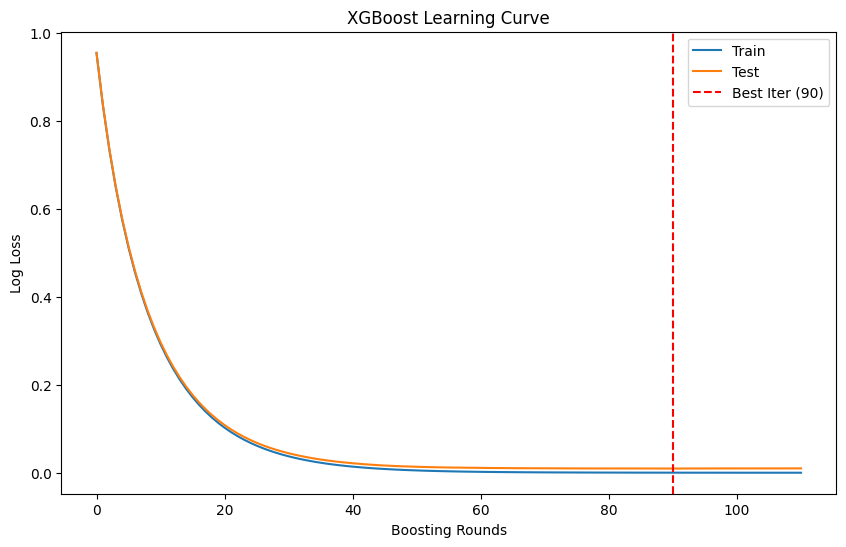

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# สร้าง DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# parameter
params = {
    "objective": "multi:softprob",
    "num_class": len(set(y_train)),
    "eval_metric": "mlogloss",
    "eta": 0.1,
    "max_depth": 6
}

# เก็บผลการเทรนแต่ละรอบ
evals_result = {}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=50
)

# plot learning curve
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10,6))
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['test']['mlogloss'], label='Test')
plt.axvline(bst.best_iteration, color='r', linestyle='--', label=f'Best Iter ({bst.best_iteration})')
plt.legend()
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curve')
plt.show()


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': len(np.unique(y_train)),
    'learning_rate': best_learning_rate,
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,
    'random_state': 42
}

evals = [(dtrain, 'train'), (dval, 'test')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=10
)


[0]	train-mlogloss:0.95476	test-mlogloss:0.95481
[10]	train-mlogloss:0.29320	test-mlogloss:0.29363
[20]	train-mlogloss:0.10366	test-mlogloss:0.10424
[30]	train-mlogloss:0.03877	test-mlogloss:0.03955
[40]	train-mlogloss:0.01543	test-mlogloss:0.01634
[50]	train-mlogloss:0.00684	test-mlogloss:0.00785
[60]	train-mlogloss:0.00364	test-mlogloss:0.00473
[70]	train-mlogloss:0.00235	test-mlogloss:0.00369
[80]	train-mlogloss:0.00170	test-mlogloss:0.00332
[90]	train-mlogloss:0.00133	test-mlogloss:0.00316
[100]	train-mlogloss:0.00105	test-mlogloss:0.00310
[110]	train-mlogloss:0.00086	test-mlogloss:0.00313
[120]	train-mlogloss:0.00075	test-mlogloss:0.00317
[127]	train-mlogloss:0.00067	test-mlogloss:0.00328


In [ ]:
print("Best iteration:", bst.best_iteration)

Best iteration: 108


In [ ]:
# ใช้ best_iteration ที่ได้จาก early stopping
best_iter = bst.best_iteration

# predict โดยระบุจำนวนรอบ
y_pred_prob = bst.predict(dtest, iteration_range=(0, best_iter+1))

# แปลง prob -> class
y_pred_class = np.argmax(y_pred_prob, axis=1)


In [ ]:
best_iter = bst.best_iteration
y_pred_prob = bst.predict(dtest, iteration_range=(0, best_iter+1))
y_pred_class = np.argmax(y_pred_prob, axis=1)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
print("AUC:", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))


[[  30    0    1]
 [   0 2132    7]
 [   0    0  274]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00      2139
           2       0.97      1.00      0.99       274

    accuracy                           1.00      2444
   macro avg       0.99      0.99      0.99      2444
weighted avg       1.00      1.00      1.00      2444

AUC: 0.9987702717135997
